## |V - Modélisation en Régression Logistique

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error , r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold
import mlflow

In [2]:
df = pd.read_csv("../data/gold.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,nb-service
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [3]:
df = df.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   Contract          7043 non-null   object 
 9   PaperlessBilling  7043 non-null   object 
 10  PaymentMethod     7043 non-null   object 
 11  MonthlyCharges    7043 non-null   float64
 12  TotalCharges      7043 non-null   float64
 13  Churn             7043 non-null   object 
 14  nb-service        7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 825.5+ KB


In [4]:
df.columns


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'nb-service'],
      dtype='object')

In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False,test_size=0.2, random_state=42)

In [6]:
labelencoder = LabelEncoder()
y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [7]:
categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',
        'Contract', 'PaperlessBilling', 'PaymentMethod','PhoneService'
       ]


categorical_transformer = OneHotEncoder(sparse=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ],
    remainder="passthrough" 
)

# Create 5 folds
seed = 13
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create model
#model_lcv = LassoCV(cv=kfold)
lasso_reg = Lasso(alpha=0.8)


pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', lasso_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse=True),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'PhoneService'])])),
                ('log_reg', Lasso(alpha=0.8))])

In [8]:
pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
experiment_id = mlflow.set_experiment("churn_model").experiment_id

# Démarrer une nouvelle exécution MLflow
with mlflow.start_run(experiment_id=experiment_id , run_name="Lasso Regularization(alpha=0.8)") as run:
    # Enregistrer les paramètres et les tags
    mlflow.log_param("alpha", lasso_reg.alpha)
    mlflow.set_tag("model_type", "lasso")
    mlflow.set_tag("regularization", True)
    
    # Adapter le pipeline à l'ensemble de formation et enregistrer le modèle entraîné
    pipe.fit(X_train, y_train)
    mlflow.sklearn.log_model(pipe, "model")
    
    # Évaluer le modèle en utilisant l'ensemble de test
    y_pred = pipe.predict(X_test)
   # accuracy = accuracy_score(y_test, y_pred)
   # f1 = f1_score(y_test, y_pred)
   # mlflow.log_metric("accuracy", accuracy)
   # mlflow.log_metric("f1", f1)
   # Calculer la MSE
    mse = mean_squared_error(y_test, y_pred)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [10]:
# évaluer les performances du modèle
print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train.round()))
print("TEST :",accuracy_score(y_test, y_pred_test.round()))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train.round()))
print("TEST :",precision_score(y_test, y_pred_test.round()))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train.round()))
print("TEST :",recall_score(y_test, y_pred_test.round()))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train.round()))
print("TEST :",f1_score(y_test, y_pred_test.round()))

#print("########  Alpha:", model_lcv.alpha_)

######## accuracy_score : 
TRAIN : 0.7903798367057153
TEST : 0.794889992902768
######## precision_score : 
TRAIN : 0.6965428937259923
TEST : 0.7277227722772277
######## recall_score : 
TRAIN : 0.3655913978494624
TEST : 0.3858267716535433
######## f1_score : 
TRAIN : 0.4795063904803878
TEST : 0.5042881646655231


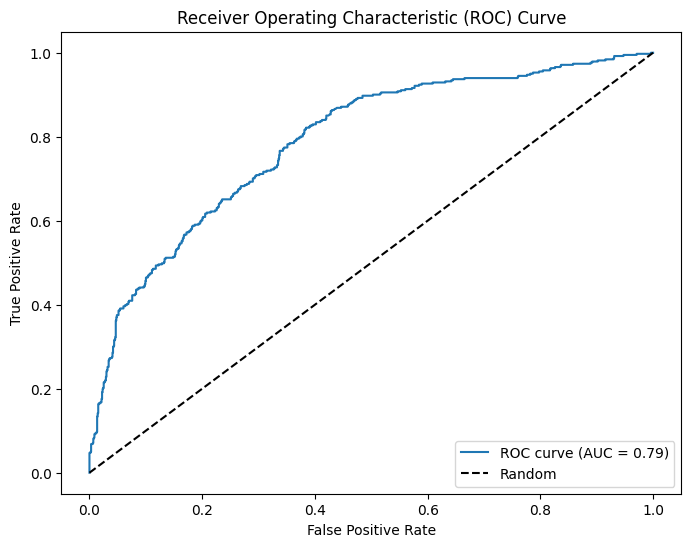

######## roc_auc_score : 
TRAIN : 0.7959585187692244
TEST : 0.7882734867285558


In [11]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  

### * Visualising the impact on coefficients

In [12]:
# Create a function to plot the magnitude of coefficients on a log scale
def plotCoef(model, info=""):
    # Plot the coeffients as bars
    fig = plt.figure(figsize=(15,3))
    fig.suptitle(type(model).__name__ + " " + info, fontsize=16)
    rects = plt.bar(np.arange(len(model.coef_)), model.coef_, color="lightblue")

    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.yscale('symlog')
    plt.show()

##### <font color="yellow"> La régression Lasso a l'avantage d'éliminer les caractéristiques qui ont une faible performance. : </font>

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315.06092882970995, tolerance: 0.08772136676281338
  model = cd_fast.enet_coordinate_descent_gram(
/home/apprenant/miniconda3/envs/sklearn-

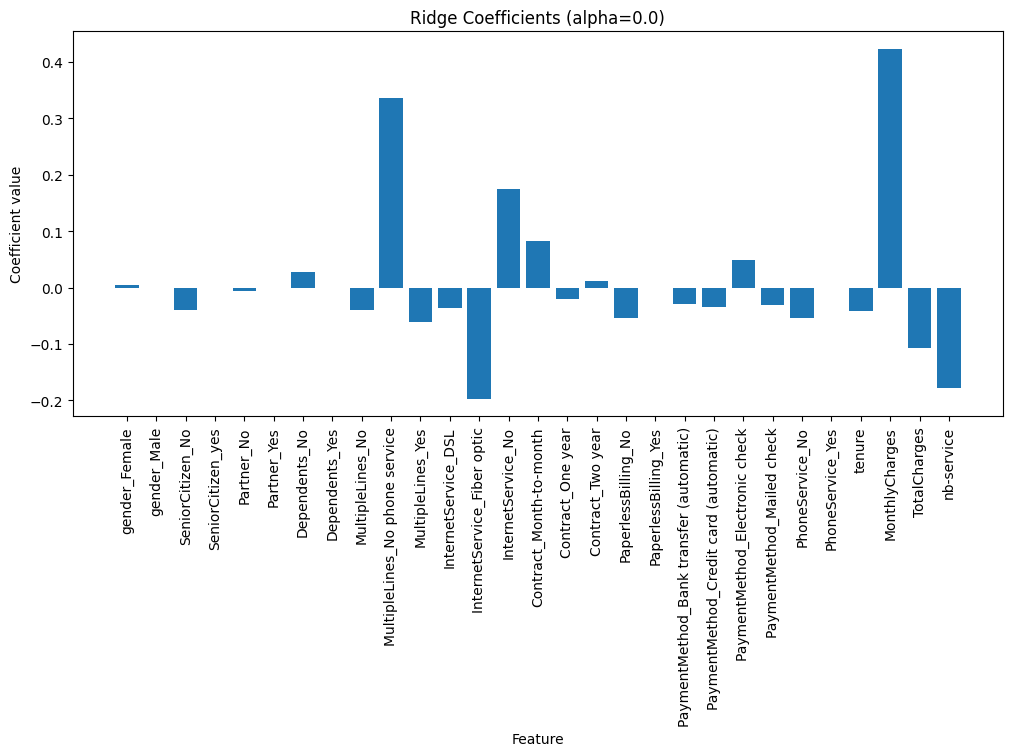

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


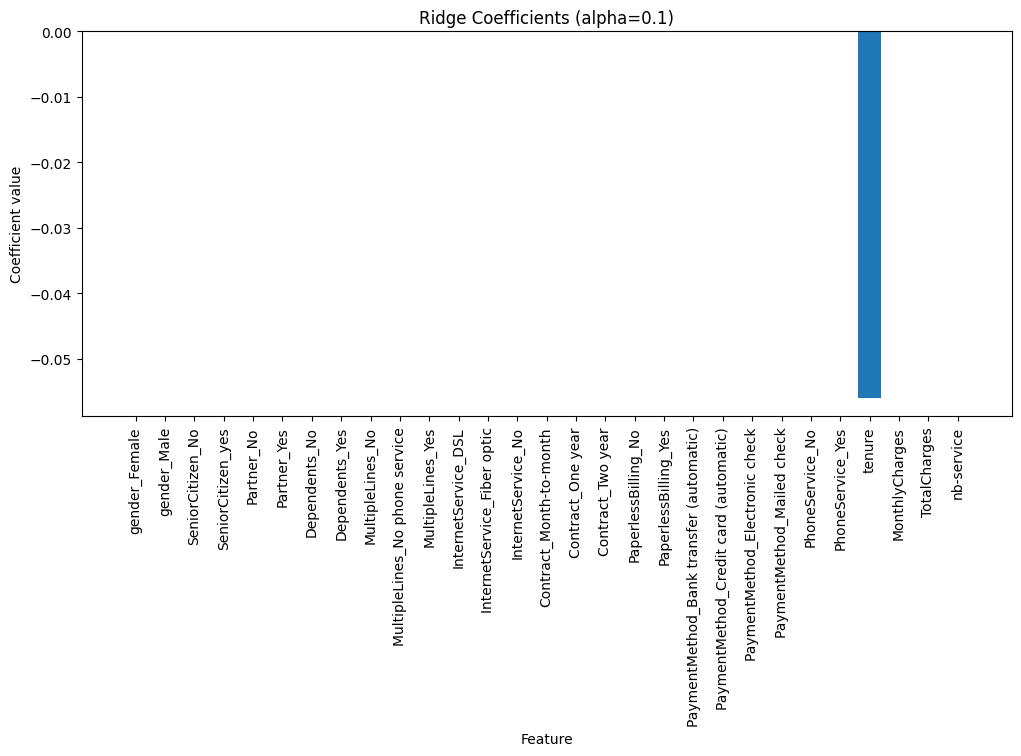

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


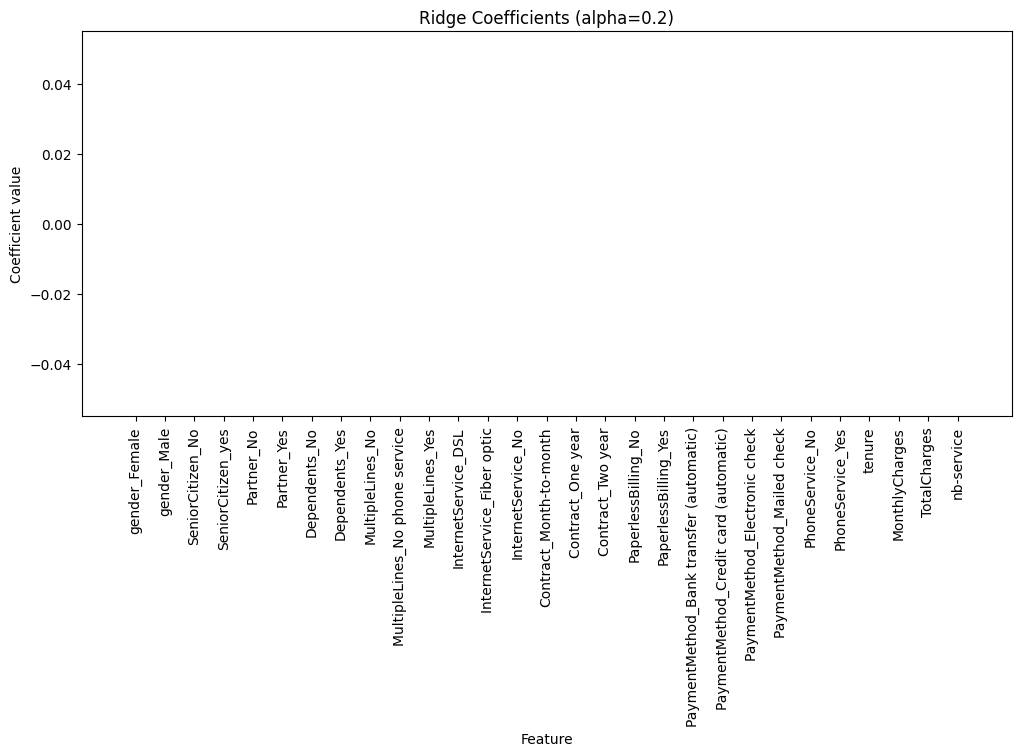

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


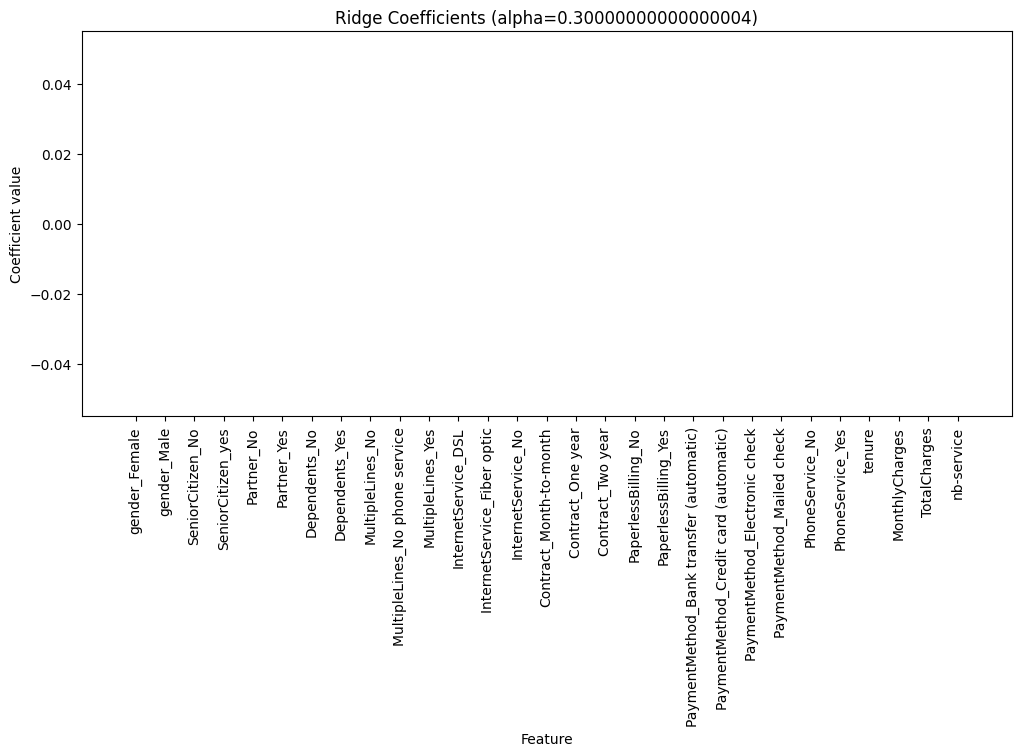

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


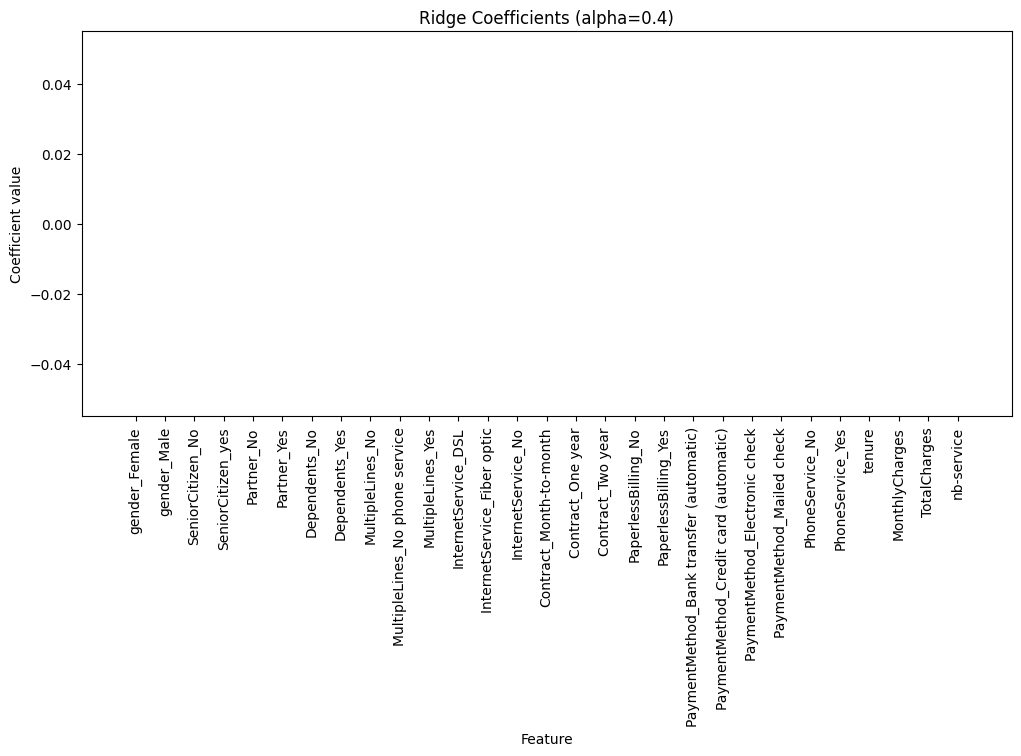

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


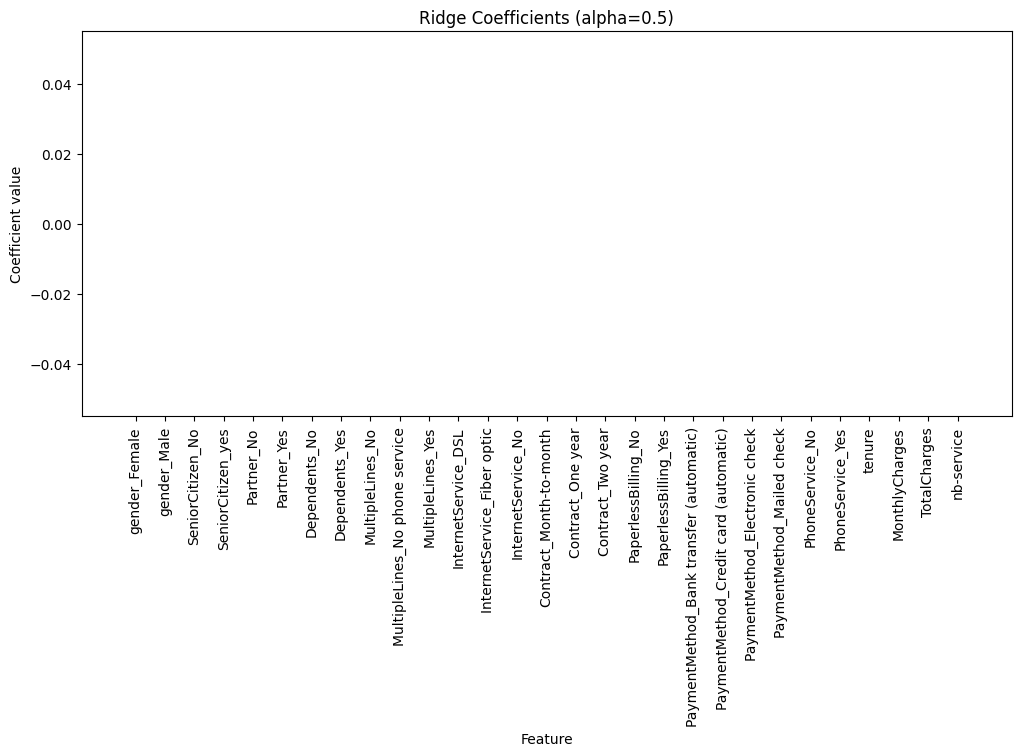

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


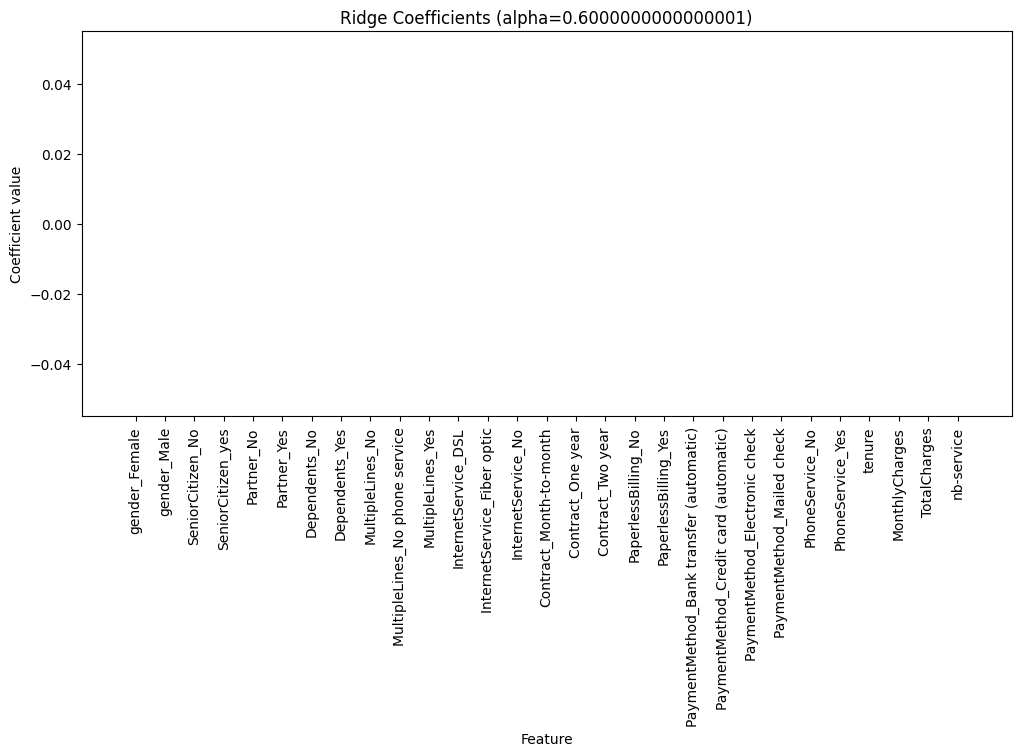

In [13]:
def plotCoefs(coefs, feature_names, title, figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(range(len(feature_names)), coefs, tick_label=feature_names)
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_title(title)
    ax.set_ylabel("Coefficient value")
    ax.set_xlabel("Feature")
    plt.show()


categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',
        'Contract', 'PaperlessBilling', 'PaymentMethod','PhoneService'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

model_rcv = LassoCV(cv=5)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', model_rcv)
])




coefs_r = []
for alpha in np.arange(0, 0.7, 0.1):
    # Set alpha value
    model_rcv.set_params(alphas=[alpha])
    
    # Fit model and get coefficients
    pipe.fit(X_train, y_train)
    coefs_r.append(model_rcv.coef_)
    
    # Get one-hot encoded feature names
    onehot_columns = preprocessor.transformers_[0][1].get_feature_names_out(categorial_features)
    feature_names = list(onehot_columns) + list(X_train.select_dtypes(include=['float64', 'int64']).columns)
    
    # Plot coefficients
    plotCoefs(model_rcv.coef_, feature_names, f"Ridge Coefficients (alpha={alpha})")


La régression Ridge et la régression Lasso ont des manières légèrement différentes de réaliser cela, et la régression Lasso a l'avantage d'éliminer les caractéristiques qui ont une faible performance.